Designs probes against a single gene. Uses the mature mRNA sequence (no introns). Blasts against transcriptome with and without introns to verify specificity. 
Author: Giacomo Glotzer. Updated: November 9, 2024. 

In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import hcrfish

Check that BLAST tools exist: 

In [2]:
hcrfish.blast.check_blast_tools()

{'makeblastdb': {'available': True, 'version': 'makeblastdb: 2.15.0+'},
 'blastn': {'available': True, 'version': 'blastn: 2.15.0+'}}

In [2]:
# Specify blast databases
transcriptome_no_introns_db = "input/dmel/transcriptome/mRNA_no_introns/mRNA_no_introns" # Includes all exons (incl. UTRs) but no introns 
transcriptome_yes_introns_db = "input/dmel/transcriptome/mRNA_yes_introns/mRNA_yes_introns" # Includes introns and exons  

In [3]:
# Load genome
genome_fasta_path = "input/dmel/genome/dm6.fa"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [17]:
# set main directory for writing files 
main_directory = 'output/dmel/'

# create main directory if it does not exist
if not os.path.exists(main_directory):
    os.makedirs(main_directory)

In [5]:
# Load transcriptome 
tr = load_transcriptome_object("mel_transcriptome") 

In [57]:
# Specify Gene 
gene_name = "Or9a"

In [58]:
# Get gene 
gene = tr.get_gene(gene_name)
gene

Gene(name=Or9a, id=Or9a, transcripts=1, chromosome=chrX, strand=-)

In [59]:
# Get transcript 
transcript = gene.get_transcript_longest_bounds()
transcript 

Transcript(name=NM_078552.3, 1176bp CDS, chrX:10458186-10459676, exons=4, introns=3, utrs=0)

In [60]:
# Get chromosome 
chromosome = gene.chromosome
chromosome

'chrX'

In [61]:
# Permitted off-targets (optionally specify a list of off-targets that are allowed)
permitted_off_targets = []

In [62]:
# Get the sequence (incl. UTRs, excl. introns)
sequence = transcript.mrna_sequence
gene.target_sequence = sequence
print(f"Sequence length: {len(sequence)}")
sequence

Sequence length: 1179


'ATGAGCGACAAGGTGAAGGGAAAAAAGCAGGAGGAAAAGGATCAATCCTTGCGGGTGCAAATTCTCGTTTATCGCTGCATGGGCATCGATTTGTGGAGCCCCACGATGGCGAATGACCGCCCGTGGCTGACCTTTGTCACAATGGGACCACTTTTCCTGTTTATGGTGCCCATGTTCCTGGCCGCCCACGAGTACATCACCCAGGTGAGCCTGCTCTCCGACACCCTGGGCTCCACCTTCGCCAGCATGCTCACCCTGGTCAAATTCCTGCTCTTCTGCTATCATCGCAAGGAGTTCGTCGGCCTGATCTACCACATCAGGGCCATTCTGGCTAAAGAAATCGAAGTGTGGCCTGATGCGCGGGAAATCATCGAGGTGGAGAACCAAAGTGACCAAATGCTCAGTCTTACGTACACTCGCTGTTTTGGACTGGCTGGAATCTTTGCGGCCCTGAAGCCCTTTGTGGGCATCATACTCTCCTCGATTCGCGGCGACGAGATTCACCTGGAGCTGCCCCACAACGGCGTTTACCCGTACGATCTCCAGGTGGTCATGTTTTATGTGCCCACCTATCTGTGGAATGTGATGGCCAGCTATAGTGCTGTAACCATGGCACTCTGCGTGGACTCGCTGCTCTTCTTTTTCACCTACAACGTGTGCGCCATTTTCAAGATCGCCAAGCACCGGATGATCCATCTGCCGGCGGTGGGCGGAAAGGAGGAGCTGGAGGGGCTCGTCCAGGTGCTGCTGCTGCACCAGAAGGGCCTCCAGATCGCCGATCACATTGCGGACAAGTACCGGCCGCTGATCTTTTTGCAGTTCTTTCTGTCCGCCTTGCAGATCTGCTTCATTGGATTCCAGGTGGCTGATCTGTTTCCCAATCCGCAGAGTCTCTACTTTATCGCCTTTGTGGGCTCGCTGCTCATCGCACTGTTCATCTACTCGAAGTGCGGCGAAAATATCAAGAGTGCCAGCCTGGATTTCGGAAACGGGCTGTAC

In [63]:
# Export each gene sequence to a fasta file 
output_dir = os.path.join(main_directory, 'gene_seq_blast_input')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

with open(f"{output_dir}/{gene.name}.fasta", 'w') as f: 
    f.write(f">{gene.name}\n{sequence}")

In [64]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'gene_seq_blast_input')
output_dir = os.path.join(main_directory, 'gene_seq_blast_output')

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# get gene sequence path 
input_path = f"{input_dir}/{gene.name}.fasta"

# Blast against DB without introns 
output_path = f"{output_dir}/{gene.name}_blasted_no_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {transcriptome_no_introns_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)

# Blast against DB with introns 
output_path = f"{output_dir}/{gene.name}_blasted_yes_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {transcriptome_yes_introns_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)


CompletedProcess(args="blastn -task blastn -query output/dmel/gene_seq_blast_input/Or9a.fasta -db input/dmel/transcriptome/mRNA_yes_introns/mRNA_yes_introns -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out output/dmel/gene_seq_blast_output/Or9a_blasted_yes_introns.csv -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4", returncode=0)

In [65]:
length_thresh = 50 

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'gene_seq_blast_output')
output_dir = os.path.join(main_directory, 'gene_seq_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# No introns
input_path = f"{input_dir}/{gene.name}_blasted_no_introns.csv"
blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_no_introns['source'] = 'no_introns'

# Yes introns
input_path = f"{input_dir}/{gene.name}_blasted_yes_introns.csv"
blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_yes_introns['source'] = 'yes_introns'

# Concatenate 
blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns], axis=0)

# Remove rows where length < length_thresh 
blast_results = blast_results[(blast_results['length'].values >= length_thresh)]

# Add column for subject gene ID 
blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1) 

# Add column for whether the query and subject gene are the same
blast_results['same_gene'] = blast_results['query_id'] == blast_results['subject_gene_id']

# Annotate if the subject gene is a permitted off-target  
blast_results['permitted_off_target'] = blast_results.apply(
    lambda x: any([keyword in x['subject_id'] for keyword in permitted_off_targets]),
    axis=1
)

# Retrieve sequence
sequence = gene.target_sequence

# Get off-targets
off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['same_gene'] == False) & # hits to other genes 
                                    (blast_results['permitted_off_target'] == False), :]  # ignore off-targets that are permitted 

# Annotate off-targets 
for j, row in off_targets.iterrows():
    sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]

# Save the annotated sequence to the gene object
gene.unique_sequence = sequence 

# Save the blast results to the gene object 
gene.blast_results = blast_results

# Save the sequence to new file 
with open(f"{output_dir}/{gene.name}_unique.fasta", 'w') as f:
    f.write(f">{gene.name}\n")
    f.write(sequence)

print(f"Unique regions have been annotated and exported to {output_dir}")

Unique regions have been annotated and exported to output/dmel/gene_seq_unique_regions


In [66]:
sequence

'ATGAGCGACAAGGTGAAGGGAAAAAAGCAGGAGGAAAAGGATCAATCCTTGCGGGTGCAAATTCTCGTTTATCGCTGCATGGGCATCGATTTGTGGAGCCCCACGATGGCGAATGACCGCCCGTGGCTGACCTTTGTCACAATGGGACCACTTTTCCTGTTTATGGTGCCCATGTTCCTGGCCGCCCACGAGTACATCACCCAGGTGAGCCTGCTCTCCGACACCCTGGGCTCCACCTTCGCCAGCATGCTCACCCTGGTCAAATTCCTGCTCTTCTGCTATCATCGCAAGGAGTTCGTCGGCCTGATCTACCACATCAGGGCCATTCTGGCTAAAGAAATCGAAGTGTGGCCTGATGCGCGGGAAATCATCGAGGTGGAGAACCAAAGTGACCAAATGCTCAGTCTTACGTACACTCGCTGTTTTGGACTGGCTGGAATCTTTGCGGCCCTGAAGCCCTTTGTGGGCATCATACTCTCCTCGATTCGCGGCGACGAGATTCACCTGGAGCTGCCCCACAACGGCGTTTACCCGTACGATCTCCAGGTGGTCATGTTTTATGTGCCCACCTATCTGTGGAATGTGATGGCCAGCTATAGTGCTGTAACCATGGCACTCTGCGTGGACTCGCTGCTCTTCTTTTTCACCTACAACGTGTGCGCCATTTTCAAGATCGCCAAGCACCGGATGATCCATCTGCCGGCGGTGGGCGGAAAGGAGGAGCTGGAGGGGCTCGTCCAGGTGCTGCTGCTGCACCAGAAGGGCCTCCAGATCGCCGATCACATTGCGGACAAGTACCGGCCGCTGATCTTTTTGCAGTTCTTTCTGTCCGCCTTGCAGATCTGCTTCATTGGATTCCAGGTGGCTGATCTGTTTCCCAATCCGCAGAGTCTCTACTTTATCGCCTTTGTGGGCTCGCTGCTCATCGCACTGTTCATCTACTCGAAGTGCGGCGAAAATATCAAGAGTGCCAGCCTGGATTTCGGAAACGGGCTGTAC

In [67]:
blast_results

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,same_gene,permitted_off_target
0,Or9a,ref|NM_078552.3|,NM_078552,100.0,1179,0,0,1,1179,1,1179,0.000000e+00,2357.0,no_introns,Or9a,True,False
0,Or9a,ref|NM_078552.3|,NM_078552,100.0,522,0,0,604,1125,741,1262,0.000000e+00,1043.0,yes_introns,Or9a,True,False
1,Or9a,ref|NM_078552.3|,NM_078552,100.0,337,0,0,1,337,1,337,0.000000e+00,674.0,yes_introns,Or9a,True,False
2,Or9a,ref|NM_078552.3|,NM_078552,100.0,272,0,0,336,607,398,669,6.290000e-153,544.0,yes_introns,Or9a,True,False
3,Or9a,ref|NM_078552.3|,NM_078552,100.0,55,0,0,1125,1179,1437,1491,2.380000e-22,110.0,yes_introns,Or9a,True,False


In [68]:
# Determine how many probes fit on each gene 
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, "B1")

print(f"There is enough space for {len(probes)} probes on {gene.name}")

There is enough space for 20 probes on Or9a


In [69]:
# Specify amplifier 
amplifier = "B3"

In [70]:
# Specify how many probes 
n_probes = 30

In [71]:
# Export excel sheet with probes and excel sheet with probe binding regions 

# Design probes
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, amplifier)

# Randomly select n_probes_per_gene probes 
np.random.seed(1)
if len(probes) < n_probes:
    indices = range(len(probes))
else: 
    indices = np.random.choice(range(len(probes)), n_probes, replace=False)
probes = [probes[i] for i in indices]
regions = [regions[i] for i in indices]

# Save probes and regions to gene object
gene.probes = probes
gene.regions = regions

# Collapse probes 
probes_collapsed = [probe for sublist in probes for probe in sublist]

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-{today}.xlsx"
# Create dataframe
df = pd.DataFrame({'Sequence': probes_collapsed})
# Add pool name column 
df['Pool name'] = f'{gene_name}-{amplifier}-{transcript.name}'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(probes_collapsed)} probes have been exported to {output_path}")


# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-regions-{today}.xlsx"
# Make a vector of the gene names for each probe 
target_genes = [gene.name for _ in range(len(probes))]
df = pd.DataFrame({'Gene': [gene.name for _ in range(len(probes))], 
                   'Region': regions, 
                   'Probe 1': [probe[0] for probe in gene.probes], 
                   'Probe 2': [probe[1] for probe in gene.probes]})
df.to_excel(output_path, index=False)

40 probes have been exported to output/dmel/IDT_sheets/Or9a-B3-NM_078552.3-2024-11-09.xlsx


In [72]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [74]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {transcriptome_no_introns_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {transcriptome_yes_introns_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted against the transcriptome")

All regions have been blasted against the transcriptome


In [76]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)

In [77]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        
        continue

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # Add column for whether the query and subject gene are the same
    blast_results['same_gene'] = gene_name == blast_results['subject_gene_id']

    # Annotate if the subject gene is a permitted off-target
    blast_results['permitted_off_target'] = blast_results.apply(
        lambda x: any([keyword in x['subject_id'] for keyword in permitted_off_targets]),
        axis=1
    )

    # Retrieve sequence
    sequence = gene.target_sequence

    # Get off-targets
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['mismatches'].values <= mismatch_thresh) & # mismatch threshold
                                    (blast_results['same_gene'] == False) & # hits to other genes
                                    (blast_results['permitted_off_target'] == False), :]  # ignore permitted off-targets 

    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


In [78]:
all_off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,same_gene,permitted_off_target


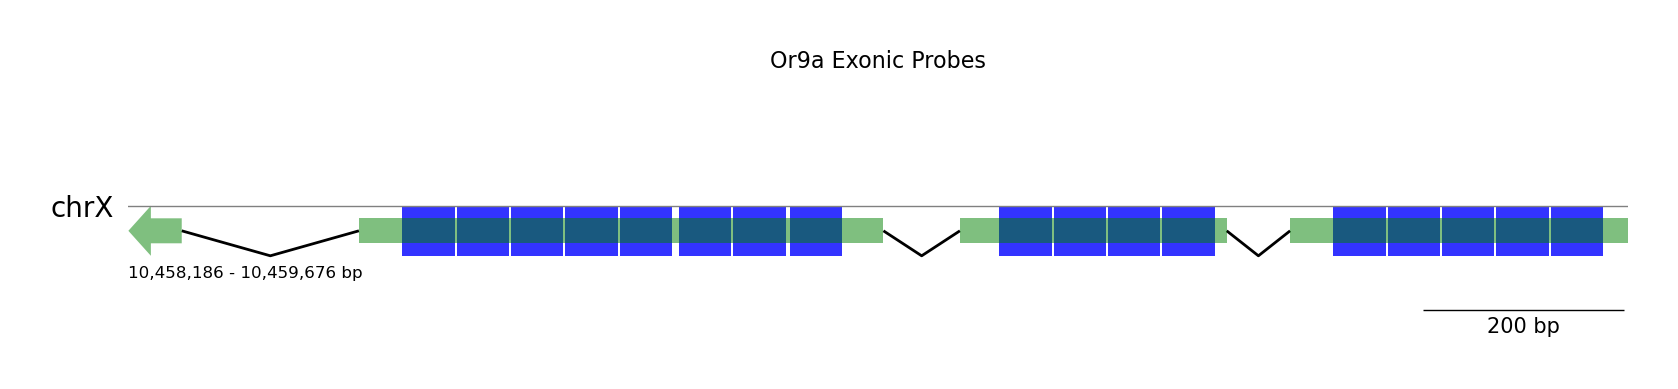

In [ ]:
white_plotting() 
# Create a new GenomeViz object
gv = GenomeViz(track_align_type="center")
gv.set_scale_bar(ymargin=0.5)

# Get bounds 
chromosome = gene.chromosome
bounds = transcript.get_bounds() 
min_start = int(bounds[0])
max_end = int(bounds[1])
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add exons to plot
exon_bounds = [[int(exon.position[0]), int(exon.position[1])] for exon in transcript.exons]
exon_bounds = sorted(exon_bounds, key=lambda x: x[0])
strand = int(np.where(transcript.strand == '+', 1, -1) )
track.add_exon_feature(exon_bounds, strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, patch_kws=dict(fc="green", ec="none", alpha=0.5), intron_patch_kws=dict(ec="black", lw=2), label='')

# Add UTRs to the plot
for utr in transcript.utrs:
    track.add_feature(int(utr.position[0]), int(utr.position[1]), strand, plotstyle="box", lw=0, fc='grey', alpha=0.5)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=0.8)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="blue", alpha=0.8)

fig = gv.plotfig()

plt.title(f"{gene_name} Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-probes-white.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)



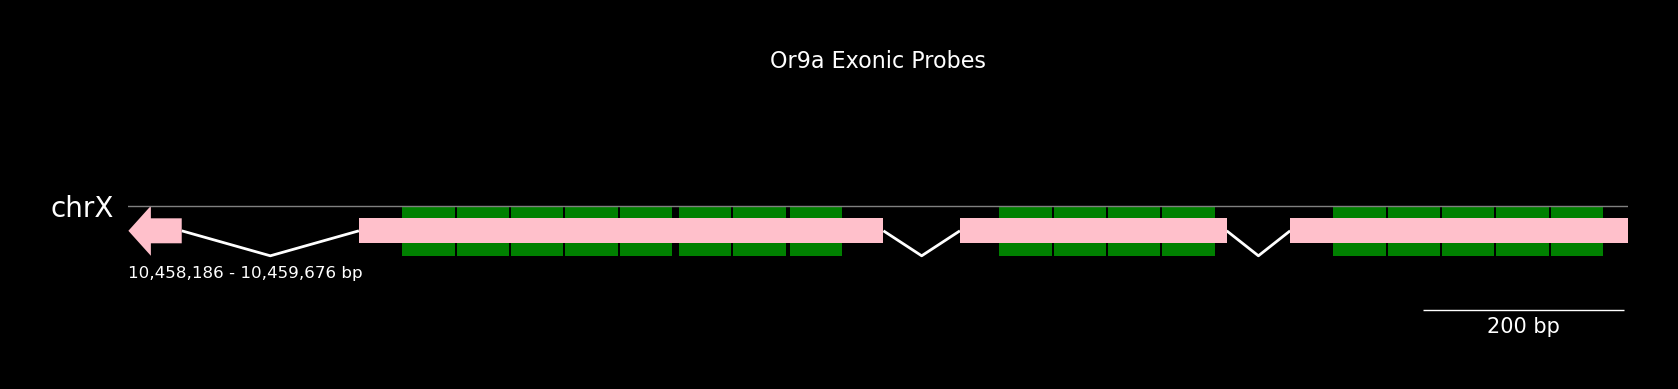

In [ ]:
black_plotting()
# Create a new GenomeViz object
gv = GenomeViz(track_align_type="center", theme="dark")
gv.set_scale_bar(ymargin=0.5)

# Get bounds 
chromosome = gene.chromosome
bounds = transcript.get_bounds() 
min_start = int(bounds[0])
max_end = int(bounds[1])
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add exons to plot
exon_bounds = [[int(exon.position[0]), int(exon.position[1])] for exon in transcript.exons]
exon_bounds = sorted(exon_bounds, key=lambda x: x[0])
strand = int(np.where(transcript.strand == '+', 1, -1) )
track.add_exon_feature(exon_bounds, strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, patch_kws=dict(fc="pink", ec="none", alpha=1), intron_patch_kws=dict(ec="white", lw=2), label='')

# Add UTRs to the plot
for utr in transcript.utrs:
    track.add_feature(int(utr.position[0]), int(utr.position[1]), strand, plotstyle="box", lw=0, fc='white', alpha=0.8)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=0.8)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="green", alpha=1)

fig = gv.plotfig()

plt.title(f"{gene_name} Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-probes-black.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

